<a href="https://colab.research.google.com/github/lwerth/INFO510-public/blob/master/final_info510.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. (Probability calculation.)
Let’s warm up with a probability calculation. The data set spread7.csv contains data from professional
(American) football games. The outcome is the difference between the favorite and underdog teams’
scores (diff in the CSV file). All of the games in this set were given a point spread of 7 points – that
is, the favorite team is expected to win by 7 points.

We’ll consider three conditional probabilities:

P(favorite wins|spread = 7)

P(favorite wins by at least 7|spread = 7)

P(favorite wins by at least 7|spread = 7 and favorite wins)


(a) Predict each of these probabilities by assuming that the quantity (outcome - point spread) is normally distributed with mean 0 and standard deviation 14.

> P(favorite wins|spread = 7) --> Posterior Mean = 41.74796342891308, Posterior SD = 0.13631478882863007

> P(favorite wins by at least 7|spread = 7) --> Posterior Mean = 17.536076215635294, Posterior SD = 0.013996165575876367

> P(favorite wins by at least 7|spread = 7 and favorite wins) --> Posterior Mean = 17.47260549235707, Posterior SD = 0.13936228694193722




In [3]:
#@title
import pandas as pd, numpy as np, scipy as sp
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
import seaborn as sns

In [1]:
#@title
import pymc3

In [ ]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [82]:
#@title
# spread = pd.read_csv('My Drive/Fall2020/info510/Final/spread7.csv')
spread = pd.read_csv(r'spread7.csv')
spread

,Unnamed: 0,home,favorite,underdog,spread,favorite_name,underdog_name,week,diff
0,21,0,17,23,7.0,LAN,NO,2,-6
1,24,1,28,23,7.0,SD,DET,2,5
2,35,1,35,23,7.0,LAN,GB,3,12
3,37,1,20,10,7.0,LAA,SEA,3,10
4,56,1,23,17,7.0,BUF,IND,5,6
...,...,...,...,...,...,...,...,...,...
132,2148,1,34,37,7.0,IND,NE,11,-3
133,2175,0,21,9,7.0,PIT,CIN,13,12
134,2210,1,14,16,7.0,HOU,GB,15,-2
135,2225,0,41,17,7.0,DAL,ATL,16,24


In [ ]:
scores = spread.drop(['Unnamed: 0', 'home', 'spread', 'favorite_name', 'underdog_name', 'week'], axis=1)
# scores.head()

fav_wins = np.array(scores['diff'].tolist())
# print(fav_wins)


In [113]:
wins = np.where(fav_wins > 0, 1, 0)

spread['favorite_win'] = wins
# print(spread.head())
# wins.mean()

# wins
#would we want to get the total number of points per game won and use that as an average for the prior mean?
#or should we leave it as is below?
#ask Dr Murphy?

0.7737226277372263

In [162]:
# P(favorite wins|spread = 7) --> (Posterior Mean = 41.74796342891308, Posterior SD = 0.13631478882863007)


# get prior mean
fav = spread.favorite
under = spread.underdog
# total = fav + under

total = [sum(i) for i in zip(fav, under)]
total_sum = sum(total)
avg = total_sum/len(total)
avg

43.481751824817515

In [172]:
#calculate the known variance (using basketball notebook example)
sigma = 7
prior_mean = avg
prior_sd = .14

mean_draws = sp.stats.norm.rvs(prior_mean, prior_sd, 10000) # generates values of theta
prior_predictions1 = pd.Series([sp.stats.norm.rvs(theta, sigma) for theta in mean_draws]) # use the thetas to generate scores

In [173]:
#look at the minimum score possible in a game

min(prior_predictions1)

17.593646450797326

In [175]:
# create posterior calc

def posterior_params1(data, prior_mean, prior_sd, sigma):
    xbar = data['diff'].mean()
    prior_prec = 1 / prior_sd ** 2
    data_prec = len(data) / sigma ** 2
    post_mean = (prior_mean * prior_prec + xbar * data_prec) / (prior_prec + data_prec)
    post_sd = np.sqrt(1/(prior_prec + data_prec))
    return post_mean, post_sd

In [176]:
# Calculate posterior

post_mean, post_sd = posterior_params1(spread, prior_mean, prior_sd, sigma)
post_mean, post_sd

(41.74796342891308, 0.13631478882863007)

In [177]:
#pull mean for posterior to plot
mean_draws = sp.stats.norm.rvs(post_mean, post_sd, 1000)
post_predictions1 = pd.Series([sp.stats.norm.rvs(theta, sigma) for theta in mean_draws])


Text(0.5, 1.0, 'Posterior Preictions in Orange')

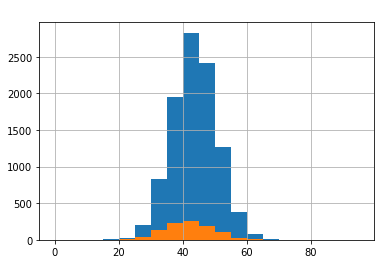

In [179]:
prior_predictions1.hist(bins = range(0, 100, 5))
plt.title("Prior Preictions", color = 'white', )

post_predictions1.hist(bins = range(0, 100, 5))
plt.title("Posterior Preictions in Orange", color = 'white')

In [180]:
# post_predictions.hist(bins = range(0, 100, 5))
# plt.title("Posterior Preictions in Orange", color = 'white')

In [148]:
# P(favorite wins by at least 7|spread = 7) --> (Posterior Mean = 17.536076215635294, Posterior SD = 0.013996165575876367)


# looking at the average difference across the teams who won by at least 7 --> 
# mean = 10.7

seven_diff = np.where(fav_wins >= 7, fav_wins, 0)
print(seven_diff)
print(seven_diff.mean())

spread['seven_diff'] = seven_diff
print(spread.head())

[ 0  0 12 10  0  0 18  0  0 14  0 14 27  0 22  0 15 17  0 24 21 18  0  0
  7  0  0 30  0 21 10  9  0 14 33  0  0  0  0 13  0  0  0 21 10 13  0 15
  0 10 21  0 11 27 20  0 32  0  0 34  0  0 14  0 27  0 31  0  0 17 10 28
  0 12  0  0  0  0 14  0 20  0 32 21 17 18  0  0  0  0 31  7  0 35  0 37
 37 10  0 17 28  0 20 28  0 30 35 13 14 11  0  0 18  0 28 27  0 32  0 10
  7 27  0  0  0 20 10 19  9  8 38  0  0 12  0 24 22]
10.861313868613138
   Unnamed: 0  home  favorite  underdog  ...  week diff seven_diff  favorite_win
0          21     0        17        23  ...     2   -6          0             0
1          24     1        28        23  ...     2    5          0             1
2          35     1        35        23  ...     3   12         12             1
3          37     1        20        10  ...     3   10         10             1
4          56     1        23        17  ...     5    6          0             1

[5 rows x 11 columns]


In [214]:
seven_fav = np.where(fav_wins >= 7, spread.favorite, 0)
spread['favorite_by_7'] = seven_fav
print(spread.head())

   Unnamed: 0  home  favorite  ...  diff  favorite_win favorite_by_7
0          21     0        17  ...    -6             0             0
1          24     1        28  ...     5             1             0
2          35     1        35  ...    12             1            35
3          37     1        20  ...    10             1            20
4          56     1        23  ...     6             1             0

[5 rows x 11 columns]


In [215]:
spread['favorite_by_7'].mean()

17.54014598540146

In [249]:
#@title
#calculate the known variance (using basketball notebook example)
sigma = 7
prior_mean2 = spread['favorite_by_7'].mean()
prior_sd2 = .14

mean_draws2 = sp.stats.norm.rvs(prior_mean2, prior_sd2, 10000) # generates values of theta
prior_predictions2 = pd.Series([sp.stats.norm.rvs(theta, sigma) for theta in mean_draws2]) # use the thetas to generate scores

In [258]:
#@title
print(min(prior_predictions2))
prior_predictions2

-7.849193341636756


0       14.273108
1       20.496753
2       13.432141
3       13.054368
4       24.502971
          ...    
9995    11.756793
9996    18.584023
9997    21.668692
9998     9.804293
9999    23.886618
Length: 10000, dtype: float64

In [251]:
#@title
def posterior_params_7(data, prior_mean, prior_sd, sigma):
    xbar = data['diff'].mean()
    prior_prec = 1 / prior_sd ** 2
    data_prec = len(data) / sigma ** 2
    post_mean = (prior_mean * prior_prec + xbar * data_prec) / (prior_prec + data_prec)
    post_sd = np.sqrt(1/(prior_prec + data_prec))
    return post_mean, post_sd

In [252]:
#@title
post_mean_7, post_sd_7 = posterior_params_7(spread, prior_mean2, prior_sd, sigma)
post_mean_7, post_sd_7

(17.536076215635294, 0.013996165575876367)

In [247]:
#@title
mean_draws_7 = sp.stats.norm.rvs(post_mean_7, post_sd_7, 1000)
post_predictions_7 = pd.Series([sp.stats.norm.rvs(theta, sigma) for theta in mean_draws_7])


Text(0.5, 1.0, 'Posterior Preictions in Orange')

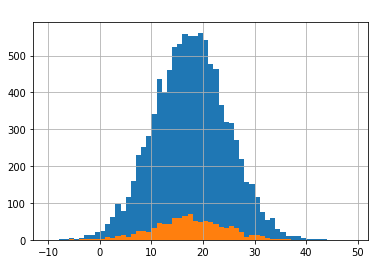

In [248]:
prior_predictions2.hist(bins = range(-10, 50, 1))
plt.title("Prior Preictions in Blue", color = 'white')

post_predictions_7.hist(bins = range(-10, 50, 1))
plt.title("Posterior Preictions in Orange", color = 'white')

In [ ]:
# P(favorite wins by at least 7|spread = 7 and favorite wins) --> (Posterior Mean = 17.47260549235707, Posterior SD = 0.13936228694193722)


In [277]:
#@title
#calculate the known variance (using basketball notebook example)
sigma_win = 7 + fav_wins.mean()
prior_mean3 = spread['favorite_by_7'].mean()
prior_sd3 = .14

mean_draws3 = sp.stats.norm.rvs(prior_mean3, prior_sd3, 10000) # generates values of theta
prior_predictions3 = pd.Series([sp.stats.norm.rvs(theta, sigma_win) for theta in mean_draws3]) # use the thetas to generate scores

In [278]:
#@title
min(prior_predictions3)

-45.447105164304716

In [279]:
#@title
def posterior_params3(data, prior_mean, prior_sd, sigma):
    xbar = data['diff'].mean()
    prior_prec = 1 / prior_sd ** 2
    data_prec = len(data) / sigma ** 2
    post_mean = (prior_mean * prior_prec + xbar * data_prec) / (prior_prec + data_prec)
    post_sd = np.sqrt(1/(prior_prec + data_prec))
    return post_mean, post_sd

In [280]:
post_mean3, post_sd3 = posterior_params3(spread, prior_mean3, prior_sd3, sigma_win)
post_mean3, post_sd3

(17.47260549235707, 0.13936228694193722)

In [282]:
mean_draws3_pos = sp.stats.norm.rvs(post_mean3, post_sd3, 1000)
post_predictions_3 = pd.Series([sp.stats.norm.rvs(theta, sigma_win) for theta in mean_draws3_pos])


Text(0.5, 1.0, 'Posterior Preictions in Orange')

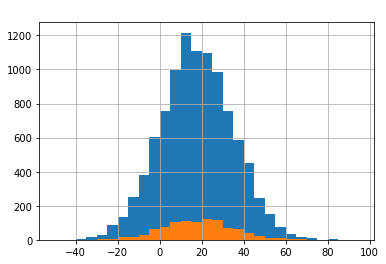

In [286]:
prior_predictions3.hist(bins = range(-50, 100, 5))
plt.title("Prior Preictions in Blue", color = 'white')

post_predictions_3.hist(bins = range(-50, 100, 5))
plt.title("Posterior Preictions in Orange", color = 'white')